In [1]:
import sys, os
import random
import torch
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from functools import partial
from se3cnn.point_kernel import gaussian_radial_function

#from gravity_dataset import GravityDataset

from se3cnn.convolution import SE3PointConvolution
from se3cnn.SO3 import torch_default_dtype
import se3cnn.point_utils as utils

torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
def gaussian_func(x, x0, sigma, axis=-1):
    """
    x: coordinates for spatial evaluation
    x0: gaussian centers
    sigma: standard deviation of gaussian
    axis: which axis represents N dimensions of x coordinates

    x and x0 must be set up for broadcasting
    Example:
    C is number of centers, N is dimensionality of Euclidean space, size is size of voxel grid
    x    [1, N, size, size, size]
    x0   [C, N, 1, 1, 1]
    """
    return np.exp(-0.5 * ((x-x0) / sigma)**2) / (np.sqrt(2 * np.pi) * sigma)

In [3]:
class GravityNet(torch.nn.Module):
    def __init__(self, num_radial=30, max_radius=2):
        super(GravityNet, self).__init__() 
        kwargs = {'radii': torch.linspace(0, max_radius, steps=num_radial, dtype=torch.float64)}

        sigma = max_radius / num_radial
        conv = SE3PointConvolution([(1,0)],
                                   [(1,1)],
                                   radii=kwargs['radii'],
                                   radial_function=partial(gaussian_radial_function, sigma= 3 * max_radius / num_radial))
        self.layers = torch.nn.ModuleList([conv])
    
    def forward(self, input, difference_mat):
        conv = self.layers[0]
        output = conv(input, difference_mat)
        return output

In [4]:
EPSILON = 1e-8
rbf_high = 2.0

def accelerations(points, masses=None):
    """
    inputs:
    -points: a list of 3-tuples of point coordinates
    -masses: a list (of equal length N) of masses
    
    returns: 
    -shape [N, 3] numpy array of accelerations under Newtonian gravity
    """
    accels = []
    if masses is None:
        masses = [1.0 for _ in range(len(points))]
    for i, ri_ in enumerate(points):
        accel_vec = np.array((0., 0., 0.))
        for j, rj_ in enumerate(points):
            rij_ = ri_ - rj_
            dij_ = np.linalg.norm(rij_)
            if (ri_ != rj_).any():
                accel_update = -rij_ / (np.power(dij_, 3) + EPSILON) * masses[j]
                accel_vec += accel_update
        accels.append(accel_vec)
    assert len(accels) == len(points)
    return np.array(accels)


def random_points_and_masses(max_points=10, min_mass=0.5, max_mass=2.0, 
                             max_coord=rbf_high, min_separation=0.5):
    """
    returns:
    -shape [N, 3] numpy array of points, where N is between 2 and max_points
    -shape [N] numpy array of masses
    """
    num_points = random.randint(2, max_points)
    candidate_points = []
    for point in range(num_points):
        candidate_points.append(
            np.array([random.uniform(-max_coord, max_coord) for _ in range(3)]))
    
    # remove points that are closer than min_separation
    output_points = []
    for point in candidate_points:
        include_point = True
        for previous_point in output_points:
            if np.linalg.norm(point - previous_point) < min_separation:
                include_point = False
        if include_point:
            output_points.append(point)
    
    points_ = np.array(output_points)
    masses_ = np.random.rand(len(output_points)) * (max_mass - min_mass) + min_mass
    return points_, masses_

In [5]:
def train(net):
    net.train()

    #loss_fn = torch.nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

    max_steps = 10001
    validation_size = 100
    print_freq = 1000
    for step in range(max_steps):
        points, masses = random_points_and_masses(10)
        accels = accelerations(points, masses)

        points = torch.from_numpy(points)
        masses = torch.from_numpy(masses).unsqueeze(0)
        accels = torch.from_numpy(accels)
        difference_mat = utils.difference_matrix(points)
        output = net(masses, difference_mat) # [3, N] 
        
        output = torch.transpose(output, 0, 1) 

        # spherical harmonics are given in y,z,x order
        permute = torch.LongTensor([2, 0, 1])
        output = output[:, permute]
        loss = torch.mean((output - accels)**2)
        #loss = loss_fn(output, accels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        step_loss = loss.item()

        if step > 0 and step % print_freq == 0:
            loss_sum = 0
            for _ in range(validation_size):
                val_points, val_masses = random_points_and_masses(50)
                val_accels = accelerations(val_points, val_masses)
                
                val_points = torch.from_numpy(val_points)
                val_masses = torch.from_numpy(val_masses).unsqueeze(0)
                val_accels = torch.from_numpy(val_accels)
                
                difference_mat = utils.difference_matrix(val_points)
                output = net(val_masses, difference_mat)
                output = torch.transpose(output, 0, 1)

                permute = torch.LongTensor([2, 0, 1])
                output = output[:, permute]

                loss = torch.mean((output - val_accels)**2)
                #loss = loss_fn(output, val_accels)
                #loss_sum += loss.item()
            print('Step {0}: validation loss = {1}'.format(step, loss.item()))

            conv = net.layers[0]
            num_radial = 30
            r_max = 2.0
            sigma = 3 * r_max / num_radial
            centers = np.linspace(0, r_max, num_radial)
            x = np.linspace(0, r_max, 100)
            fig, ax = plt.subplots(1)
            weight = conv.kernel.weight.detach().numpy()
            radial_function = lambda x: np.sum(np.multiply(gaussian_func(x.reshape(-1, 1), centers.reshape(1, -1), sigma),
                                                           weight.reshape(1, -1)), axis=-1)
            y = radial_function(x)
            ax.plot(x, y)
            l1_prefactor = np.sqrt(4 * np.pi/3.)
            wigner_prefactor = np.sqrt(3)
            prefactor = l1_prefactor * wigner_prefactor
#             prefactor = 1.0
            start = 25
            ax.plot(x[start:], -1/ (x[start:]**2) * prefactor)
            plt.savefig('validation_result_{0}.png'.format(step / print_freq))

        if step % 500 == 0:
            print('Step {0}, Loss {1}'.format(step, step_loss)) 
    return net

def test(net):
    net.eval()
    loss_fn = torch.nn.MSELoss()

def main():
    net = GravityNet()
    train(net)

Step 0, Loss 0.11493720388143916
Step 500, Loss 0.008560198113179117
Step 1000: validation loss = 1.0376031257331426
Step 1000, Loss 0.030891415349310353
Step 1500, Loss 0.03950042087278648
Step 2000: validation loss = 0.31270380665584185
Step 2000, Loss 0.0017493365383725425
Step 2500, Loss 0.00602990408728491
Step 3000: validation loss = 0.5900499908972793
Step 3000, Loss 0.0011623359160828405
Step 3500, Loss 0.009837685821091593
Step 4000: validation loss = 0.15889112912754713
Step 4000, Loss 0.05883161798990313
Step 4500, Loss 0.01167717339496683
Step 5000: validation loss = 0.1062983642646018
Step 5000, Loss 0.15102175032407775
Step 5500, Loss 0.033716887497196396
Step 6000: validation loss = 0.020399756628758297
Step 6000, Loss 0.012526492401743854
Step 6500, Loss 0.01106642048012438
Step 7000: validation loss = 0.22230289594063604
Step 7000, Loss 0.044127729425170764
Step 7500, Loss 0.0761135034257006
Step 8000: validation loss = 0.6098558902168283
Step 8000, Loss 0.003240487508

GravityNet(
  (layers): ModuleList(
    (0): SE3PointConvolution (SE3PointKernel ([(1, 0)] -> [(1, 1)], radii=tensor([0.0000, 0.0690, 0.1379, 0.2069, 0.2759, 0.3448, 0.4138, 0.4828, 0.5517,
            0.6207, 0.6897, 0.7586, 0.8276, 0.8966, 0.9655, 1.0345, 1.1034, 1.1724,
            1.2414, 1.3103, 1.3793, 1.4483, 1.5172, 1.5862, 1.6552, 1.7241, 1.7931,
            1.8621, 1.9310, 2.0000])), kwargs={})
  )
)

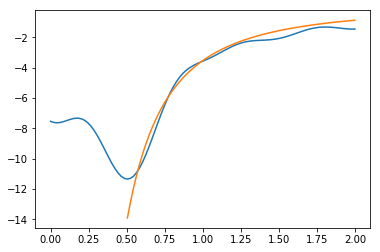

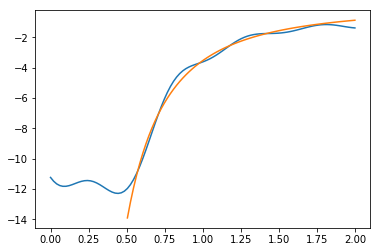

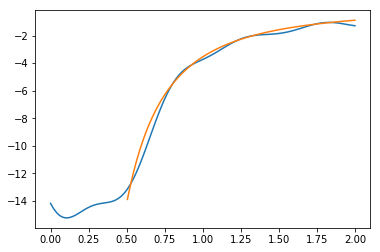

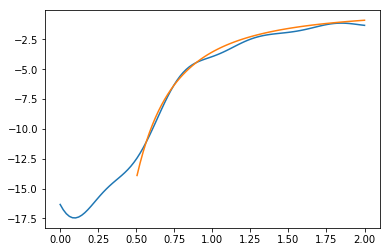

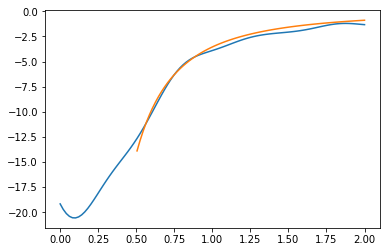

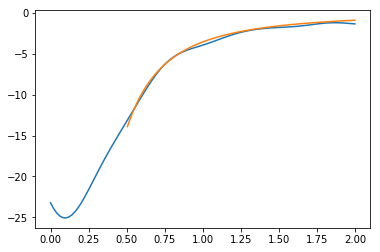

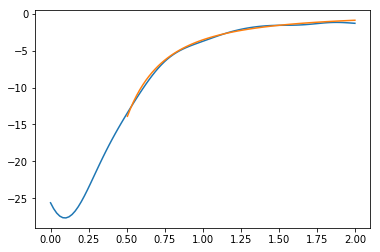

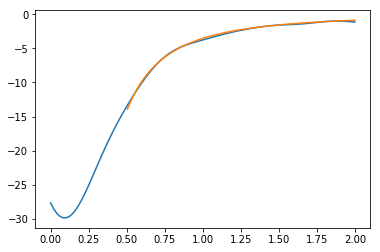

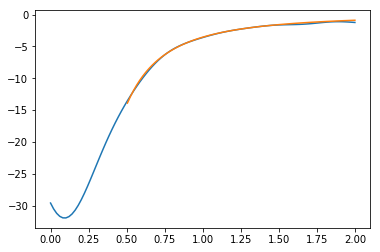

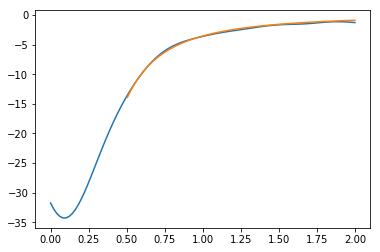

In [6]:
net = GravityNet(num_radial=30)
train(net)